# **Regularization Regression 을 이용한 Odor 분석**

In [1]:
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R

.libPaths("/content/drive/MyDrive/R packages")
.libPaths()

[1] "/content/drive/MyDrive/R packages" "/usr/local/lib/R/site-library"    
[3] "/usr/lib/R/site-library"           "/usr/lib/R/library"               


## **0. Packages Installation**

In [3]:
%%R

# install.packages("corrplot")                  
# install.packages("PerformanceAnalytics")      # 상관분석 시각화
# install.packages("pls")                       # pls
# install.packages("caret")         
# install.packages("stringr")
# install.packages("devtools")
# install.packages("lmtest")      # Durbin-Watson test (잔차의 독립성)
# install.packages("car")         # 다중공선성
# install.packages("Metrics")     # RMSE, MAPE


library(Metrics)
library(car)
library(lmtest)
library(devtools)
library(stringr)
library(corrplot)
library(PerformanceAnalytics)
library(pls)
library(caret)

R[write to console]: Loading required package: carData

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


R[write to console]: Loading required package: usethis

R[write to console]: corrplot 0.84 loaded

R[write to console]: Loading required package: xts

R[write to console]: 
Attaching package: ‘PerformanceAnalytics’


R[write to console]: The following object is masked from ‘package:graphics’:

    legend


R[write to console]: 
Attaching package: ‘pls’


R[write to console]: The following object is masked from ‘package:corrplot’:

    corrplot


R[write to console]: The following object is masked from ‘package:stats’:

    loadings


R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘caret’


R[write to console]: The followin

**plsVarSel은  R version 4.0.5에서 지원하지 않으므로, Version을 지정해 다운해야된다.**

In [4]:
%%R
# install_version("plsVarSel", version = "0.9.6", repos = "http://cran.us.r-project.org")    # VIP
library(plsVarSel)

## **I. Data**

- Standardization

- Log + Standardization

In [5]:
%%R

setwd("/content/drive/Othercomputers/내 컴퓨터/라벨이 지정되지 않은 볼륨[F]/교수님/PLS 양돈 농가/데이터/")

In [6]:
%%R

odor <- read.csv("New_data.csv", fileEncoding = "euc-kr")               # 원 데이터
st <- read.csv("standardization.csv", fileEncoding = "euc-kr")          # Standardization data
lst <- read.csv("log standardization.csv", fileEncoding = "euc-kr")  # Log + Standardization data

In [7]:
%%R

print(head(st, 3))
print(summary(st))

          ou        nh3        h2s         mm        dms       dmds        aca
1 -0.8486138 -1.0437124 -0.5517391 -0.5509004 0.01329568 -0.2655626 -0.9240932
2 -0.8486138 -1.0319730 -0.1372241  0.1952964 7.37708082 -0.2655626  0.7047421
3 -0.7504659 -0.9634928 -0.6886547 -0.5528325 0.85098361 -0.2655626  0.2393974
         ppa        iba       bta        iva        vla          ph          pc
1 -1.0088217 -0.9706879 -1.041122 -0.7927354 -0.6066553 -0.55264192 -0.94886130
2  1.7399088  1.9318039  2.029148  1.8193896  1.4132597  0.93091831  0.81159707
3  0.8961961  0.9724988  1.585714  0.9605351  0.9189869  0.07842075 -0.08652035
          id          sk
1 -0.6442860 -0.27605863
2  0.3415235  1.15389997
3 -0.4297275 -0.09827999
       ou               nh3               h2s                mm          
 Min.   :-0.9812   Min.   :-1.0437   Min.   :-0.8585   Min.   :-0.55283  
 1st Qu.:-0.7505   1st Qu.:-0.7463   1st Qu.:-0.7000   1st Qu.:-0.55283  
 Median :-0.3844   Median :-0.3413   Media

In [8]:
%%R

print(head(lst, 3))
print(summary(lst))

         ou       nh3        h2s         mm      dms       dmds       aca
1 -1.235849 -2.061472 -0.3632959 -0.6387885 1.471740 -0.3059095 -1.084505
2 -1.235849 -1.954099  0.3417926  1.0646023 2.831587 -0.3059095  0.773626
3 -0.828202 -1.481942 -0.8007143 -0.8958656 2.081442 -0.3059095  0.596986
         ppa       iba       bta       iva       vla         ph         pc
1 -1.4333782 -1.748890 -1.688962 -1.876210 -1.349337 -0.6483724 -4.8035459
2  1.0079342  1.310006  1.139025  1.363714  1.306571  1.0992944  0.8472289
3  0.7937802  0.985959  1.042285  1.079080  1.139036  0.5572743  0.3691276
           id       sk
1 -1.16073774 0.177013
2  0.90524283 1.135620
3 -0.05457066 0.383262
       ou                nh3                h2s                mm         
 Min.   :-2.35264   Min.   :-2.06147   Min.   :-2.0759   Min.   :-0.8959  
 1st Qu.:-0.82820   1st Qu.:-0.67722   1st Qu.:-0.8480   1st Qu.:-0.8959  
 Median :-0.01195   Median : 0.05146   Median : 0.2067   Median :-0.8959  
 Mean   : 0.

## **II. Regualarization**

- **trainContral 함수의 LOOCV 사용.**

- Ridge Reg　:　RSS($\beta$)　+　$\lambda \sum_{j=1}^{p}\beta_j^2$

- Lasso Reg　:　RSS($\beta$)　+　$\lambda \sum_{j=1}^{p}|\beta_j|$

- Elastic Net Reg　:　RSS($\beta$)　+　$\lambda_1 \sum_{j=1}^{p}\beta_j^2　+　\lambda_2 \sum_{j=1}^{p}|\beta_j|$

\
- glmnet　:　 RSS($\beta$)　+　$\lambda[(1-\alpha) \sum_{j=1}^{p}\beta_j^2　+　\alpha \sum_{j=1}^{p}|\beta_j|]$

  - $\alpha=1$ : Lasso
  - $\alpha=0$ : Ridge
  - $0<\alpha<1$ : Elastic Net

  - $\lambda ≥ 0$ 　　if lambda = 0 then It is the same as Normal Regression

### **1. Response and Independent**

In [9]:
%%R

st_y <- st$ou
st_X <- as.matrix(subset(st, select = -c(ou)))

lst_y <- lst$ou
lst_X <- as.matrix(subset(lst, select = -c(ou)))


print(head(st_y, 3))
print(head(st_X, 3))

[1] -0.8486138 -0.8486138 -0.7504659
         nh3        h2s         mm        dms       dmds        aca        ppa
1 -1.0437124 -0.5517391 -0.5509004 0.01329568 -0.2655626 -0.9240932 -1.0088217
2 -1.0319730 -0.1372241  0.1952964 7.37708082 -0.2655626  0.7047421  1.7399088
3 -0.9634928 -0.6886547 -0.5528325 0.85098361 -0.2655626  0.2393974  0.8961961
         iba       bta        iva        vla          ph          pc         id
1 -0.9706879 -1.041122 -0.7927354 -0.6066553 -0.55264192 -0.94886130 -0.6442860
2  1.9318039  2.029148  1.8193896  1.4132597  0.93091831  0.81159707  0.3415235
3  0.9724988  1.585714  0.9605351  0.9189869  0.07842075 -0.08652035 -0.4297275
           sk
1 -0.27605863
2  1.15389997
3 -0.09827999


### **2. Ridge LOO Regression**


#### **- Hyperparameter Range**

In [10]:
%%R 

rid_Grid <- expand.grid(.alpha = 0,
                        .lambda = seq(0.01, 1, 0.01))

#### **- Model training**

In [11]:
%%R

control_ridge <- trainControl(method = "LOOCV",
                              repeats = 1)

In [12]:
%%R

st_rid_model <- train(ou ~ .,
                      data = st,
                      method = "glmnet",
                      tuneGrid = rid_Grid,
                      metric = "MSE",
                      trControl = control_ridge)

lst_rid_model <- train(ou ~ .,
                       data = lst,
                       method = "glmnet",
                       tuneGrid = rid_Grid,
                       metric = "MSE",
                       trControl = control_ridge)

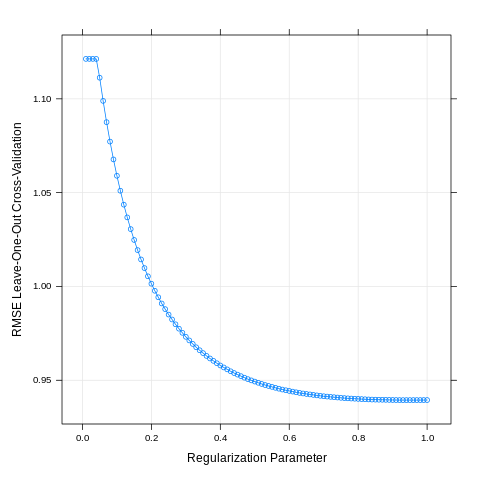

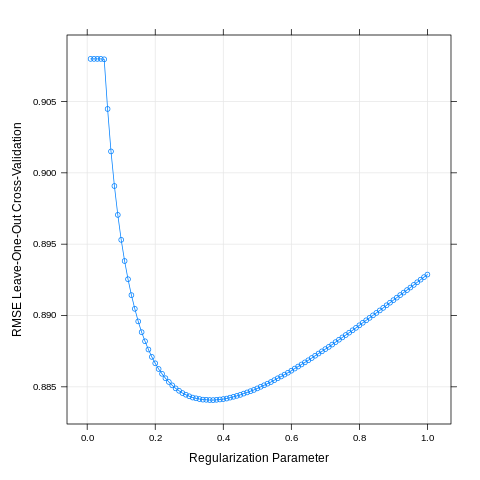

In [13]:
%%R

print(plot(st_rid_model))
print(plot(lst_rid_model))

In [14]:
%%R

### 최적의 lambda
st_best_rid_parameter <- st_rid_model$bestTune
lst_best_rid_parameter <- lst_rid_model$bestTune

print("St :")
print(st_best_rid_parameter)
print("=====================")
print("Log St : ")
print(lst_best_rid_parameter)

[1] "St :"
   alpha lambda
94     0   0.94
[1] "====================="
[1] "Log St : "
   alpha lambda
37     0   0.37


In [15]:
%%R

### 회귀 계수
# which_best_st_rid_parameter <- as.numeric(rownames(st_rid_model$bestTune))
# st_rid_beta <- st_rid_model$finalModel$beta[, which_best_st_rid_parameter]
# print(round(st_rid_beta, 4))

# print("========================================================================")

# which_best_lst_rid_parameter <- as.numeric(rownames(lst_rid_model$bestTune))
# lst_rid_beta <- lst_rid_model$finalModel$beta[, which_best_lst_rid_parameter]
# print(round(lst_rid_beta, 4))

NULL


In [16]:
%%R

st_best_rid_model <- st_rid_model$finalModel
st_rid_beta <- coef(st_best_rid_model, s = st_rid_model$bestTune$lambda)
print(round(st_rid_beta[,1], 3))

print("===================================================")

lst_best_rid_model <- lst_rid_model$finalModel
lst_rid_beta <- coef(lst_best_rid_model, s = lst_rid_model$bestTune$lambda)
print(round(lst_rid_beta[,1], 3))


(Intercept)         nh3         h2s          mm         dms        dmds 
      0.000       0.086      -0.016       0.201      -0.077      -0.039 
        aca         ppa         iba         bta         iva         vla 
      0.080       0.025      -0.004       0.061      -0.028      -0.018 
         ph          pc          id          sk 
     -0.011       0.068       0.042       0.030 
[1] "==================================================="
(Intercept)         nh3         h2s          mm         dms        dmds 
      0.000       0.289       0.063       0.228      -0.027       0.048 
        aca         ppa         iba         bta         iva         vla 
      0.101       0.027      -0.035       0.042       0.026       0.132 
         ph          pc          id          sk 
     -0.050      -0.009      -0.039       0.090 


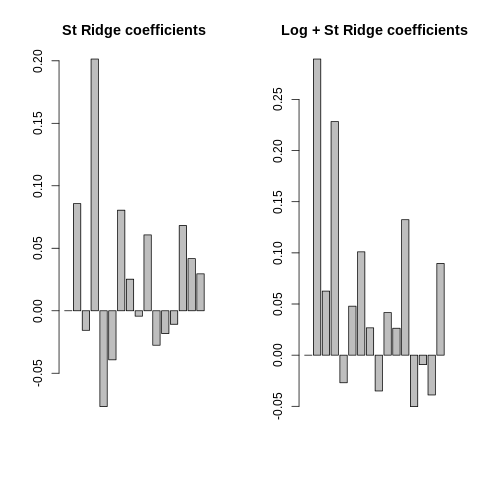

In [17]:
%%R

par(mfrow = c(1,2))
barplot(st_rid_beta[1:length(st_rid_beta[,1])], main = "St Ridge coefficients")
barplot(lst_rid_beta[1:length(lst_rid_beta[,1])], main = "Log + St Ridge coefficients")
par(mfrow = c(1,1))

#### **- New Data set**

In [18]:
%%R

th = 0.01

st_sel_rid <- st_rid_beta[abs(st_rid_beta[,1]) > th, 1]
cat("St 선택된 변수 : ", names(st_sel_rid), "(", length(st_sel_rid), "개)", "\n")

st_del_rid <- st_rid_beta[abs(st_rid_beta[,1]) <= th, 1]
cat("St 제거된 변수 : ", names(st_del_rid), "(", length(st_del_rid), "개)", "\n")

lst_sel_rid <- lst_rid_beta[abs(lst_rid_beta[,1]) > th, 1]
cat("Log + St 선택된 변수 : ", names(lst_sel_rid), "(", length(lst_sel_rid), "개)", "\n")

lst_del_rid <- lst_rid_beta[abs(lst_rid_beta[,1]) <= th, 1]
cat("Log + St 제거된 변수 : ", names(lst_del_rid), "(", length(lst_del_rid), "개)", "\n")

St 선택된 변수 :  nh3 h2s mm dms dmds aca ppa bta iva vla ph pc id sk ( 14 개) 
St 제거된 변수 :  (Intercept) iba ( 2 개) 
Log + St 선택된 변수 :  nh3 h2s mm dms dmds aca ppa iba bta iva vla ph id sk ( 14 개) 
Log + St 제거된 변수 :  (Intercept) pc ( 2 개) 


In [19]:
%%R

st_rid <- cbind(st["ou"], st[names(st_sel_rid)])
print(head(st_rid, 3))

lst_rid <- cbind(lst["ou"], lst[names(lst_sel_rid)])
print(head(lst_rid, 3))

          ou        nh3        h2s         mm        dms       dmds        aca
1 -0.8486138 -1.0437124 -0.5517391 -0.5509004 0.01329568 -0.2655626 -0.9240932
2 -0.8486138 -1.0319730 -0.1372241  0.1952964 7.37708082 -0.2655626  0.7047421
3 -0.7504659 -0.9634928 -0.6886547 -0.5528325 0.85098361 -0.2655626  0.2393974
         ppa       bta        iva        vla          ph          pc         id
1 -1.0088217 -1.041122 -0.7927354 -0.6066553 -0.55264192 -0.94886130 -0.6442860
2  1.7399088  2.029148  1.8193896  1.4132597  0.93091831  0.81159707  0.3415235
3  0.8961961  1.585714  0.9605351  0.9189869  0.07842075 -0.08652035 -0.4297275
           sk
1 -0.27605863
2  1.15389997
3 -0.09827999
         ou       nh3        h2s         mm      dms       dmds       aca
1 -1.235849 -2.061472 -0.3632959 -0.6387885 1.471740 -0.3059095 -1.084505
2 -1.235849 -1.954099  0.3417926  1.0646023 2.831587 -0.3059095  0.773626
3 -0.828202 -1.481942 -0.8007143 -0.8958656 2.081442 -0.3059095  0.596986
         ppa

### **3. LASSO LOO Regression**


#### **- Hyperparameter Range**

In [20]:
%%R 

las_Grid <- expand.grid(.alpha = 1,
                        .lambda = seq(0.01, 1, 0.01))

#### **- Model training**

In [21]:
%%R

control_lasso <- trainControl(method = "LOOCV",
                              repeats = 1)

In [22]:
%%R

st_las_model <- train(ou ~ .,
                      data = st,
                      method = "glmnet",
                      tuneGrid = las_Grid,
                      metric = "MSE",
                      trControl = control_lasso)

lst_las_model <- train(ou ~ .,
                       data = lst,
                       method = "glmnet",
                       tuneGrid = las_Grid,
                       metric = "MSE",
                       trControl = control_lasso)

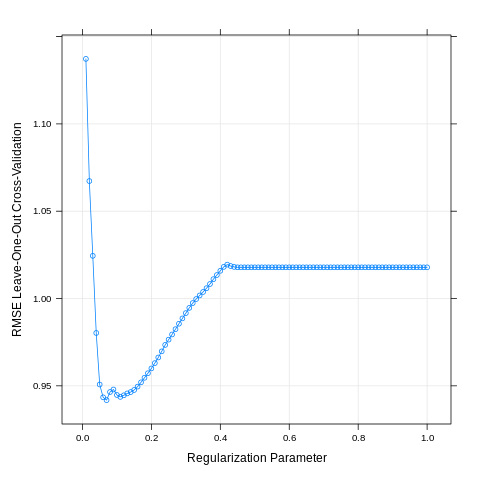

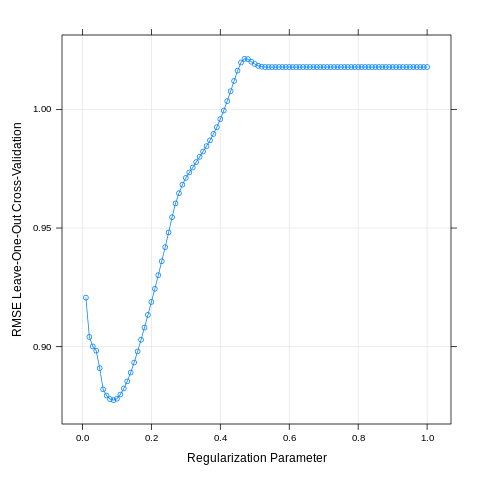

In [23]:
%%R

print(plot(st_las_model))
print(plot(lst_las_model))

In [24]:
%%R

### 최적의 lambda
st_best_las_parameter <- st_las_model$bestTune
lst_best_las_parameter <- lst_las_model$bestTune

print("St :")
print(st_best_las_parameter)
print("=====================")
print("Log St : ")
print(lst_best_las_parameter)

[1] "St :"
  alpha lambda
7     1   0.07
[1] "====================="
[1] "Log St : "
  alpha lambda
9     1   0.09


In [25]:
# %%R

# ### 회귀 계수
# which_best_st_las_parameter <- as.numeric(rownames(st_las_model$bestTune))
# st_las_beta <- st_las_model$finalModel$beta[, which_best_st_las_parameter]
# print(round(st_las_beta, 4))


# which_best_lst_las_parameter <- as.numeric(rownames(lst_las_model$bestTune))
# lst_las_beta <- lst_las_model$finalModel$beta[, which_best_lst_las_parameter]
# print(round(lst_las_beta, 4))

In [26]:
%%R

st_best_las_model <- st_las_model$finalModel
st_las_beta <- coef(st_best_las_model, s = st_las_model$bestTune$lambda)
print(round(st_las_beta[,1], 3))

print("===================================================")

lst_best_las_model <- lst_las_model$finalModel
lst_las_beta <- coef(lst_best_las_model, s = lst_las_model$bestTune$lambda)
print(round(lst_las_beta[,1], 3))

(Intercept)         nh3         h2s          mm         dms        dmds 
      0.000       0.075       0.000       0.351      -0.094      -0.061 
        aca         ppa         iba         bta         iva         vla 
      0.137       0.000       0.000       0.090       0.000       0.000 
         ph          pc          id          sk 
      0.000       0.006       0.000       0.000 
[1] "==================================================="
(Intercept)         nh3         h2s          mm         dms        dmds 
      0.000       0.323       0.000       0.190       0.000       0.000 
        aca         ppa         iba         bta         iva         vla 
      0.029       0.000       0.000       0.000       0.000       0.160 
         ph          pc          id          sk 
      0.000       0.000       0.000       0.051 


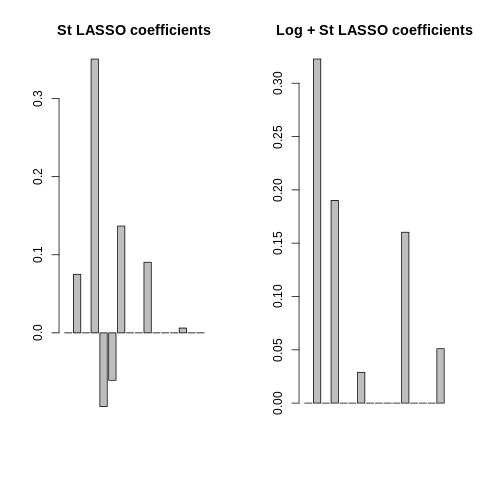

In [27]:
%%R

par(mfrow = c(1,2))
barplot(st_las_beta[1:length(st_las_beta[,1])], main = "St LASSO coefficients")
barplot(lst_las_beta[1:length(lst_las_beta[,1])], main = "Log + St LASSO coefficients")
par(mfrow = c(1,1))

#### **- New Data set**

In [28]:
%%R

th = 0

st_sel_las <- st_las_beta[abs(round(st_las_beta[,1], 3)) > th, 1]
cat("St 선택된 변수 : ", names(st_sel_las), "(", length(st_sel_las), "개)", "\n")

st_del_las <- st_las_beta[abs(round(st_las_beta[,1], 3)) == th, 1]
cat("St 제거된 변수 : ", names(st_del_las), "(", length(st_del_las), "개)", "\n")

lst_sel_las <- lst_las_beta[abs(round(lst_las_beta[,1], 3)) > th, 1]
cat("Log + St 선택된 변수 : ", names(lst_sel_las), "(", length(lst_sel_las), "개)", "\n")

lst_del_las <- lst_las_beta[abs(round(lst_las_beta[,1], 3)) == th, 1]
cat("Log + St 제거된 변수 : ", names(lst_del_las), "(", length(lst_del_las), "개)", "\n")

St 선택된 변수 :  nh3 mm dms dmds aca bta pc ( 7 개) 
St 제거된 변수 :  (Intercept) h2s ppa iba iva vla ph id sk ( 9 개) 
Log + St 선택된 변수 :  nh3 mm aca vla sk ( 5 개) 
Log + St 제거된 변수 :  (Intercept) h2s dms dmds ppa iba bta iva ph pc id ( 11 개) 


In [29]:
%%R

st_las <- cbind(st["ou"], st[names(st_sel_las)])
print(head(st_las, 3))

lst_las <- cbind(lst["ou"], lst[names(lst_sel_las)])
print(head(lst_las, 3))

          ou        nh3         mm        dms       dmds        aca       bta
1 -0.8486138 -1.0437124 -0.5509004 0.01329568 -0.2655626 -0.9240932 -1.041122
2 -0.8486138 -1.0319730  0.1952964 7.37708082 -0.2655626  0.7047421  2.029148
3 -0.7504659 -0.9634928 -0.5528325 0.85098361 -0.2655626  0.2393974  1.585714
           pc
1 -0.94886130
2  0.81159707
3 -0.08652035
         ou       nh3         mm       aca       vla       sk
1 -1.235849 -2.061472 -0.6387885 -1.084505 -1.349337 0.177013
2 -1.235849 -1.954099  1.0646023  0.773626  1.306571 1.135620
3 -0.828202 -1.481942 -0.8958656  0.596986  1.139036 0.383262


### **3. Elastic net LOO Regression**


#### **- Hyperparameter Range**

In [30]:
%%R 

elas_Grid <- expand.grid(.alpha = seq(0.1, 1, 0.1),
                         .lambda = seq(0.01, 0.5, 0.01))

#### **- Model training**

In [31]:
%%R

control_elas <- trainControl(method = "LOOCV",
                             repeats = 1)

In [32]:
%%R

st_elas_model <- train(ou ~ .,
                       data = st,
                       method = "glmnet",
                       tuneGrid = elas_Grid,
                       metric = "MSE",
                       trControl = control_elas)

lst_elas_model <- train(ou ~ .,
                        data = lst,
                        method = "glmnet",
                        tuneGrid = elas_Grid,
                        metric = "MSE",
                        trControl = control_elas)

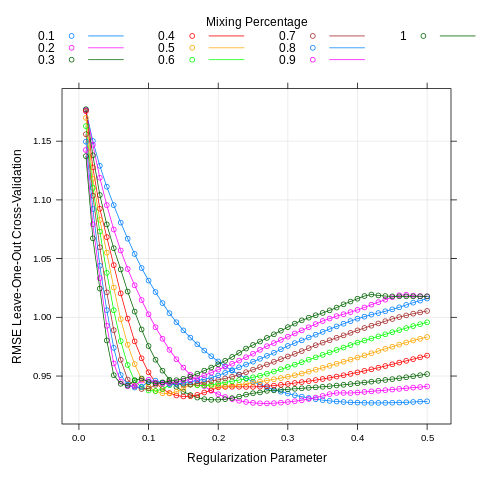

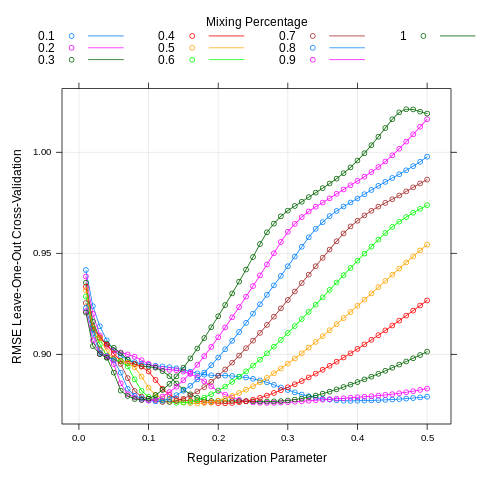

In [33]:
%%R

print(plot(st_elas_model))
print(plot(lst_elas_model))

In [34]:
%%R

### 최적의 lambda
st_best_elas_parameter <- st_elas_model$bestTune
lst_best_elas_parameter <- lst_elas_model$bestTune

print("St :")
print(st_best_elas_parameter)
print("=====================")
print("Log St : ")
print(lst_best_elas_parameter)

[1] "St :"
   alpha lambda
77   0.2   0.27
[1] "====================="
[1] "Log St : "
    alpha lambda
217   0.5   0.17


In [35]:
# %%R

# ### 회귀 계수
# which_best_st_elas_parameter <- as.numeric(rownames(st_elas_model$bestTune))
# st_elas_beta <- st_elas_model$finalModel$beta[, which_best_st_elas_parameter]
# print(round(st_elas_beta, 4))

# which_best_lst_elas_parameter <- as.numeric(rownames(lst_elas_model$bestTune))
# lst_elas_beta <- lst_elas_model$finalModel$beta[, which_best_lst_elas_parameter]
# print(round(lst_elas_beta, 4))

In [36]:
%%R

st_best_elas_model <- st_elas_model$finalModel
st_elas_beta <- coef(st_best_elas_model, s = st_elas_model$bestTune$lambda)
print(round(st_elas_beta[,1], 3))

print("===================================================")

lst_best_elas_model <- lst_elas_model$finalModel
lst_elas_beta <- coef(lst_best_elas_model, s = lst_elas_model$bestTune$lambda)
print(round(lst_elas_beta[,1], 3))

(Intercept)         nh3         h2s          mm         dms        dmds 
      0.000       0.082       0.000       0.286      -0.083      -0.046 
        aca         ppa         iba         bta         iva         vla 
      0.103       0.000       0.000       0.063       0.000       0.000 
         ph          pc          id          sk 
      0.000       0.062       0.000       0.000 
[1] "==================================================="
(Intercept)         nh3         h2s          mm         dms        dmds 
      0.000       0.303       0.000       0.184       0.000       0.000 
        aca         ppa         iba         bta         iva         vla 
      0.042       0.000       0.000       0.000       0.000       0.140 
         ph          pc          id          sk 
      0.000       0.000       0.000       0.058 


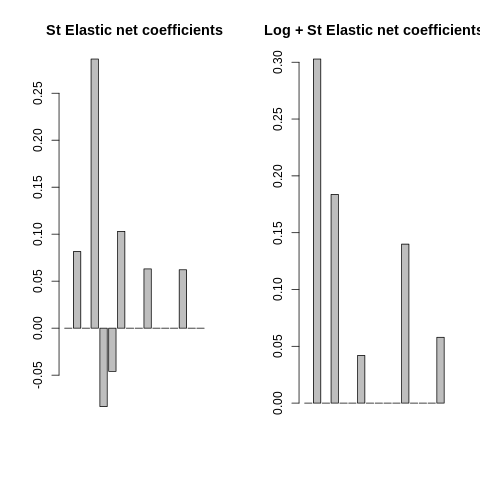

In [37]:
%%R

par(mfrow = c(1,2))
barplot(st_elas_beta[1:length(st_elas_beta[,1])], main = "St Elastic net coefficients")
barplot(lst_elas_beta[1:length(lst_elas_beta[,1])], main = "Log + St Elastic net coefficients")
par(mfrow = c(1,1))

#### **- New Data set**

In [38]:
%%R

th = 0.01

st_sel_elas <- st_elas_beta[abs(st_elas_beta[,1]) > th, 1]
cat("St 선택된 변수 : ", names(st_sel_elas), "(", length(st_sel_elas), "개)", "\n")

st_del_elas <- st_elas_beta[abs(st_elas_beta[,1]) <= th, 1]
cat("St 제거된 변수 : ", names(st_del_elas), "(", length(st_del_elas), "개)", "\n")

lst_sel_elas <- lst_elas_beta[abs(lst_elas_beta[,1]) > th, 1]
cat("Log + St 선택된 변수 : ", names(lst_sel_elas), "(", length(lst_sel_elas), "개)", "\n")

lst_del_elas <- lst_elas_beta[abs(lst_elas_beta[,1]) <= th, 1]
cat("Log + St 제거된 변수 : ", names(lst_del_elas), "(", length(lst_del_elas), "개)", "\n")

St 선택된 변수 :  nh3 mm dms dmds aca bta pc ( 7 개) 
St 제거된 변수 :  (Intercept) h2s ppa iba iva vla ph id sk ( 9 개) 
Log + St 선택된 변수 :  nh3 mm aca vla sk ( 5 개) 
Log + St 제거된 변수 :  (Intercept) h2s dms dmds ppa iba bta iva ph pc id ( 11 개) 


In [39]:
%%R

st_elas <- cbind(st["ou"], st[names(st_sel_elas)])
print(head(st_elas, 3))

lst_elas <- cbind(lst["ou"], lst[names(lst_sel_elas)])
print(head(lst_elas, 3))

          ou        nh3         mm        dms       dmds        aca       bta
1 -0.8486138 -1.0437124 -0.5509004 0.01329568 -0.2655626 -0.9240932 -1.041122
2 -0.8486138 -1.0319730  0.1952964 7.37708082 -0.2655626  0.7047421  2.029148
3 -0.7504659 -0.9634928 -0.5528325 0.85098361 -0.2655626  0.2393974  1.585714
           pc
1 -0.94886130
2  0.81159707
3 -0.08652035
         ou       nh3         mm       aca       vla       sk
1 -1.235849 -2.061472 -0.6387885 -1.084505 -1.349337 0.177013
2 -1.235849 -1.954099  1.0646023  0.773626  1.306571 1.135620
3 -0.828202 -1.481942 -0.8958656  0.596986  1.139036 0.383262


### **4. 가설 검정**

#### **- Standardiztion**

In [40]:
%%R

### Ridge
st_rid_reg <- lm(ou ~ ., data = st_rid)
st_rid_res <- residuals(st_rid_reg)
st_rid_bp <- round(bptest(st_rid_reg)$p.value, 3)
st_rid_dw <- round(dwtest(st_rid_reg)$p.value, 3)
st_rid_sh <- round(shapiro.test(st_rid_res)$p.value, 3)

### Lasso
st_las_reg <- lm(ou ~ ., data = st_las)
st_las_res <- residuals(st_las_reg)
st_las_bp <- round(bptest(st_las_reg)$p.value, 3)
st_las_dw <- round(dwtest(st_las_reg)$p.value, 3)
st_las_sh <- round(shapiro.test(st_las_res)$p.value, 3)

### Elastic Net 
st_elas_reg <- lm(ou ~ ., data = st_elas)
st_elas_res <- residuals(st_elas_reg)
st_elas_bp <- round(bptest(st_elas_reg)$p.value, 3)
st_elas_dw <- round(dwtest(st_elas_reg)$p.value, 3)
st_elas_sh <- round(shapiro.test(st_elas_res)$p.value, 3)

st_res <- t(data.frame(Ridge = c(st_rid_bp, st_rid_dw, st_rid_sh), 
                       Lasso = c(st_las_bp, st_las_dw, st_las_sh),
                       Elastic = c(st_elas_bp, st_elas_dw, st_elas_sh),
                       row.names = c("등분산성", "독립성", "정규성")))
st_res

        등분산성 독립성 정규성
Ridge      0.965  0.322      0
Lasso      0.982  0.128      0
Elastic    0.982  0.128      0


#### **- Log + Standardization**

In [41]:
%%R

### Ridge
lst_rid_reg <- lm(ou ~ ., data = lst_rid)
lst_rid_res <- residuals(lst_rid_reg)
lst_rid_bp <- round(bptest(lst_rid_reg)$p.value, 3)
lst_rid_dw <- round(dwtest(lst_rid_reg)$p.value, 3)
lst_rid_sh <- round(shapiro.test(lst_rid_res)$p.value, 3)

### Lasso
lst_las_reg <- lm(ou ~ ., data = lst_las)
lst_las_res <- residuals(lst_las_reg)
lst_las_bp <- round(bptest(lst_las_reg)$p.value, 3)
lst_las_dw <- round(dwtest(lst_las_reg)$p.value, 3)
lst_las_sh <- round(shapiro.test(lst_las_res)$p.value, 3)

### Elalstic Net 
lst_elas_reg <- lm(ou ~ ., data = lst_elas)
lst_elas_res <- residuals(lst_elas_reg)
lst_elas_bp <- round(bptest(lst_elas_reg)$p.value, 3)
lst_elas_dw <- round(dwtest(lst_elas_reg)$p.value, 3)
lst_elas_sh <- round(shapiro.test(lst_elas_res)$p.value, 3)

lst_res <- t(data.frame(Ridge = c(lst_rid_bp, lst_rid_dw, lst_rid_sh), 
                       Lasso = c(lst_las_bp, lst_las_dw, lst_las_sh),
                       Elalstic = c(lst_elas_bp, lst_elas_dw, lst_elas_sh),
                       row.names = c("등분산성", "독립성", "정규성")))
lst_res

         등분산성 독립성 정규성
Ridge       0.490  0.162  0.677
Lasso       0.919  0.179  0.231
Elalstic    0.919  0.179  0.231


### **5. VIF**

#### **- Standardization**

[1] 49.255
[1] 5.829
[1] 5.829
  nh3   h2s    mm   dms  dmds   aca   ppa   bta   iva   vla    ph    pc    id 
 3.89  1.26  1.68  1.28  1.59  8.75 41.28 23.01 49.26 44.84 46.55 33.19  6.16 
   sk 
10.41 
 nh3   mm  dms dmds  aca  bta   pc 
2.50 1.46 1.15 1.31 3.76 4.50 5.83 
 nh3   mm  dms dmds  aca  bta   pc 
2.50 1.46 1.15 1.31 3.76 4.50 5.83 


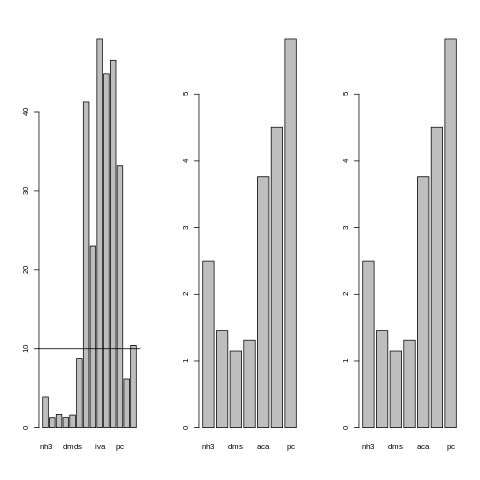

In [42]:
%%R

st_rid_vif <- round(vif(st_rid_reg), 3)
st_las_vif <- round(vif(st_las_reg), 3)
st_elas_vif <- round(vif(st_elas_reg), 3)

print(max(st_rid_vif))
print(max(st_las_vif))
print(max(st_elas_vif))

print(round(st_rid_vif, 2))
print(round(st_las_vif, 2))
print(round(st_elas_vif, 2))

par(mfrow = c(1,3))
barplot(st_rid_vif) ; abline(h = 10)
barplot(st_las_vif) ; abline(h = 10)
barplot(st_elas_vif) ; abline(h = 10)
par(mfrow = c(1,1))

#### **- Log + Standardization**

[1] 69.816
[1] 2.956
[1] 2.956
  nh3   h2s    mm   dms  dmds   aca   ppa   iba   bta   iva   vla    ph    id 
 2.16  1.37  2.56  1.55  1.22  2.97 28.25 69.82 31.17 46.03 17.64  6.73  3.08 
   sk 
 3.36 
 nh3   mm  aca  vla   sk 
1.25 1.26 1.87 2.74 2.96 
 nh3   mm  aca  vla   sk 
1.25 1.26 1.87 2.74 2.96 


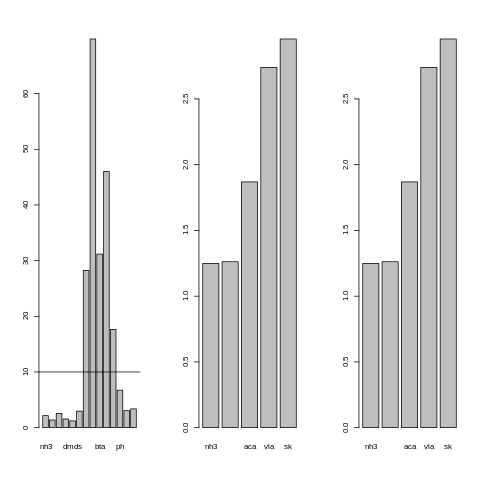

In [43]:
%%R

lst_rid_vif <- round(vif(lst_rid_reg), 3)
lst_las_vif <- round(vif(lst_las_reg), 3)
lst_elas_vif <- round(vif(lst_elas_reg), 3)

print(max(lst_rid_vif))
print(max(lst_las_vif))
print(max(lst_elas_vif))

print(round(lst_rid_vif, 2))
print(round(lst_las_vif, 2))
print(round(lst_elas_vif, 2))

par(mfrow = c(1,3))
barplot(lst_rid_vif) ; abline(h = 10)
barplot(lst_las_vif) ; abline(h = 10)
barplot(lst_elas_vif) ; abline(h = 10)
par(mfrow = c(1,1))

## **III. Result**

### **1. Function reg_loocv**

- 가설검정과 VIF에 문제가 없는 데이터셋만 사용.

- lst_las, lst_elas

In [44]:
%%R

reg_loocv <- function(data) {
                  
                  predict <- rep(0, nrow(data))
                  real <- rep(0, nrow(data))

                  for (i in 1 : nrow(data)) {
                      train <- data[-i, 1:ncol(data)]
                      test <- data[i, 1:ncol(data)]

                      test_y = test[1:nrow(test), 1]
                      test_X = test[1:nrow(test), 2:ncol(test)]

                      reg_fit = lm(ou ~ . , data = train)

                      predict[i] = predict(reg_fit, newdata = test_X)
                      real[i] = test_y
                  }
                  return (list(predict = predict, real = real))
              }

In [45]:
%%R

lst_las_result <- reg_loocv(lst_las)
lst_las_pred <- lst_las_result$predict  ; lst_las_real <- lst_las_result$real

lst_elas_result <- reg_loocv(lst_elas)
lst_elas_pred <- lst_elas_result$predict  ; lst_elas_real <- lst_elas_result$real

### **2. Results**

#### **- Data Frame**

In [46]:
%%R

lst_las_result_df <- data.frame(real = lst_las_real, pred = lst_las_pred, diff = (lst_las_real - lst_las_pred))
lst_elas_result_df <- data.frame(real = lst_elas_real, pred = lst_elas_pred, diff = (lst_elas_real - lst_elas_pred))

print(head(lst_las_result_df, 5))
print(head(lst_elas_result_df, 5))

        real       pred        diff
1 -1.2358488 -1.3136168  0.07776801
2 -1.2358488  0.1875634 -1.42341215
3 -0.8282020 -0.4608869 -0.36731513
4  0.7325348 -0.6298180  1.36235280
5 -1.2025163 -0.4755955 -0.72692081
        real       pred        diff
1 -1.2358488 -1.3136168  0.07776801
2 -1.2358488  0.1875634 -1.42341215
3 -0.8282020 -0.4608869 -0.36731513
4  0.7325348 -0.6298180  1.36235280
5 -1.2025163 -0.4755955 -0.72692081


#### **- Plots**

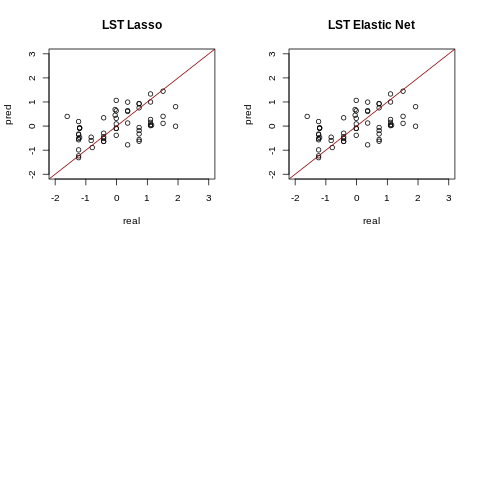

In [52]:
%%R

par(mfrow = c(2,2))
plot(lst_las_real, lst_las_pred, 
     xlim = c(-2,3), ylim = c(-2,3), 
     xlab = "real", ylab = "pred", main = "LST Lasso")
abline(a = 0, b = 1, col = "darkred")

plot(lst_elas_real, lst_elas_pred, 
     xlim = c(-2,3), ylim = c(-2,3), 
     xlab = "real", ylab = "pred", main = "LST Elastic Net")
abline(a = 0, b = 1, col = "darkred")
par(mfrow = c(1,1))

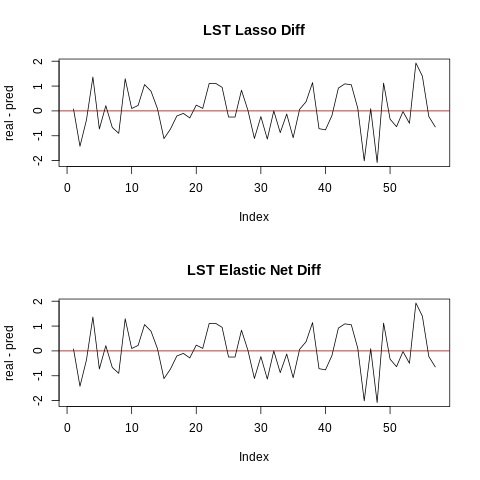

In [48]:
%%R

par(mfrow = c(2,1))
plot(lst_las_result_df$diff, type = "l",
     main = "LST Lasso Diff", ylab = "real - pred")
abline(h = 0, col = "darkred")

plot(lst_elas_result_df$diff, type = "l",
     main = "LST Elastic Net Diff", ylab = "real - pred")
abline(h = 0, col = "darkred")
par(mfrow = c(1,1))

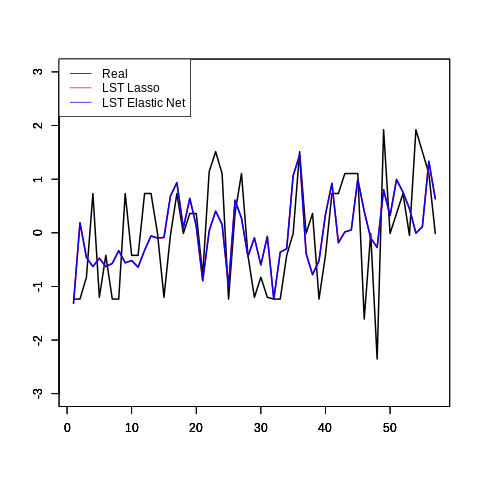

In [49]:
%%R

plot(lst_las_real, type = "l", col = "black", lwd = 2, xlab = "", ylab = "", ylim = c(-3, 3))
par(new = T)  ; plot(lst_las_pred, type = "l", col = "red", lwd = 2, xlab = "", ylab = "", ylim = c(-3, 3))
par(new = T)  ; plot(lst_elas_pred, type = "l", col = "blue", lwd = 2, xlab = "", ylab = "", ylim = c(-3, 3))
legend("topleft", legend = c("Real", "LST Lasso", "LST Elastic Net"), lty = 1,  col = c("black", "red", "blue"))

#### **- Finals**

In [50]:
%%R

lst_real <- lst$ou

### lst_las
lst_las_r2 <- round(cor(lst_las_real, lst_las_pred)^2, 3)
lst_las_rmse <- round(rmse(lst_las_real, lst_las_pred), 3)
lst_las_mape <- round(mape(lst_las_real, lst_las_pred))

### lst_elas
lst_elas_r2 <- round(cor(lst_elas_real, lst_elas_pred)^2, 3)
lst_elas_rmse <- round(rmse(lst_elas_real, lst_elas_pred), 3)
lst_elas_mape <- round(mape(lst_elas_real, lst_elas_pred))


result_df <- data.frame(lst_las = c(lst_las_r2, lst_las_rmse, lst_las_mape), 
                        lst_elas = c(lst_elas_r2, lst_elas_rmse, lst_elas_mape),
                        row.names = c("R2", "RMSE", "MAPE"))
result_df

     lst_las lst_elas
R2     0.270    0.270
RMSE   0.861    0.861
MAPE   5.000    5.000
